# RNN

-----------------------------------------

## Q 4.1 Counting Bits 

---------------------------------------

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class BinarySequenceDataset(Dataset):
    def __init__(self, num_samples=100_000, max_len=16):
        self.sequences = []
        self.labels = []
        for _ in range(num_samples):
            seq_len = torch.randint(1, max_len + 1, (1,)).item()
            sequence = torch.randint(0, 2, (seq_len,)).tolist()
            label = sum(sequence)
            self.sequences.append(sequence)
            self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64).to(device)
    sequences = [torch.tensor(seq, dtype=torch.float32).unsqueeze(1).to(device) for seq in sequences]
    padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32).to(device)
    return padded_sequences, labels, lengths


dataset = BinarySequenceDataset(num_samples=100_000, max_len=16)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Print sequences from the first batch in the DataLoader
for batch in train_loader:
    padded_sequences, labels, lengths = batch
    print("\n Sample batch from DataLoader:")
    for i in range(min(5, len(labels))):  # Print up to 5 sequences
        print(f"Sequence {i+1} (padded): {padded_sequences[i][:lengths[i]].squeeze().tolist()}, "
              f"Label: {labels[i].item()}")
    break


Using device: cpu

 Sample batch from DataLoader:
Sequence 1 (padded): [1.0, 0.0, 1.0, 0.0, 1.0, 1.0], Label: 4.0
Sequence 2 (padded): [1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0], Label: 6.0
Sequence 3 (padded): [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0], Label: 6.0
Sequence 4 (padded): [0.0, 1.0, 1.0], Label: 2.0
Sequence 5 (padded): [0.0, 0.0, 1.0, 1.0], Label: 2.0


In [ ]:
class RNNBitCounter(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=128, output_size=1, rnn_type="RNN"):
        super(RNNBitCounter, self).__init__()
        rnn_layer = {"RNN": nn.RNN, "LSTM": nn.LSTM, "GRU": nn.GRU}[rnn_type]
        self.rnn = rnn_layer(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths):
        lengths = lengths.cpu()
        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        final_states = output[range(len(lengths)), lengths - 1]
        return self.fc(final_states).squeeze(1)

rnn_model = RNNBitCounter(input_size=1, hidden_size=128, output_size=1, rnn_type="RNN").to(device)

In [ ]:
import random

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_baseline_loss = 0.0

    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            random_predictions = [random.randint(0, length.item()) for length in lengths]
            random_predictions = torch.tensor(random_predictions, dtype=torch.float32).to(labels.device)
            baseline_loss = criterion(random_predictions, labels)
            total_baseline_loss += baseline_loss.item()

    return total_loss / len(data_loader), total_baseline_loss / len(data_loader)


def train_rnn(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.L1Loss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
    
        model.train()
        train_loss = 0.0
        for sequences, labels, lengths in train_loader:
        
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss, baseline_loss = evaluate(model, val_loader, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Random Baseline Loss: {baseline_loss:.4f}")



In [ ]:
import matplotlib.pyplot as plt

def test_generalization(model, max_length=32):
    model.eval()
    lengths = range(1, max_length + 1)
    maes = []

    with torch.no_grad():
        for length in lengths:
            sequences = [torch.randint(0, 2, (length,)).tolist() for _ in range(1000)]
            labels = [sum(seq) for seq in sequences]

            lengths_tensor = torch.tensor([len(seq) for seq in sequences], dtype=torch.int64).to(device)
            sequences = [torch.tensor(seq, dtype=torch.float32).unsqueeze(1).to(device) for seq in sequences]
            padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True).to(device)
            labels = torch.tensor(labels, dtype=torch.float32).to(device)

            outputs = model(padded_sequences, lengths_tensor.cpu())
            maes.append(torch.mean(torch.abs(outputs - labels)).item())

    plt.plot(lengths, maes, label="MAE")
    plt.xlabel("Sequence Length")
    plt.ylabel("MAE")
    plt.title("Generalization Performance")
    plt.legend()
    plt.show()


In [13]:
# Training the model
train_rnn(rnn_model, train_loader, val_loader, num_epochs=10, lr=0.001)


Epoch [1/10], Train Loss: 0.0805, Val Loss: 0.0391, Random Baseline Loss: 2.5521
Epoch [2/10], Train Loss: 0.0725, Val Loss: 0.0526, Random Baseline Loss: 2.5601
Epoch [3/10], Train Loss: 0.0685, Val Loss: 0.0634, Random Baseline Loss: 2.5649
Epoch [4/10], Train Loss: 0.0671, Val Loss: 0.0268, Random Baseline Loss: 2.5989
Epoch [5/10], Train Loss: 0.0628, Val Loss: 0.0816, Random Baseline Loss: 2.5600
Epoch [6/10], Train Loss: 0.0580, Val Loss: 0.0746, Random Baseline Loss: 2.5725
Epoch [7/10], Train Loss: 0.0573, Val Loss: 0.0454, Random Baseline Loss: 2.5602
Epoch [8/10], Train Loss: 0.0626, Val Loss: 0.0249, Random Baseline Loss: 2.5829
Epoch [9/10], Train Loss: 0.0557, Val Loss: 0.0531, Random Baseline Loss: 2.5242
Epoch [10/10], Train Loss: 0.0575, Val Loss: 0.0475, Random Baseline Loss: 2.5525


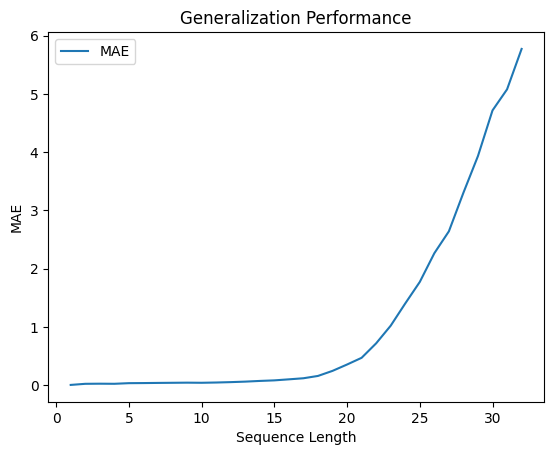

Test MAE: 0.0479


In [15]:

# Testing generalization performance
test_generalization(rnn_model, max_length=32)

# Final evaluation on test set
test_loss , _= evaluate(rnn_model, test_loader, nn.L1Loss())
print(f"Test MAE: {test_loss:.4f}")


So, from the plot, we could initially obviously infer that as for sequence grater than 16 isn't trained, thus MAE increases rapidly to an inefficient model score. Also we could see some increase for MAE from 1 to 16, which is due to more no. of bits. Similar logic applies for 17 to 32.

Random baseline would always have a considerable error/loss as it doesnt have any basis of showing output, but just random, which shows uniform probability of getting correct output.